# Frecency Sampling

To be able to quickly prototype the Federated Learning algorithm, a dataset is required.
This notebook is based on a fake frecency dataset that was designed to be very interpretable and at the same time close to the actual data.
The assumption for the data generation is that the current frecency algorithm is perfect. By sampling based on this axiom, we can check if the algorithm really finds the global optimum.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [47]:
import sys
sys.path.insert(0, '..')
from utils import one_hot

## Sampling the model input

These are weights that describe how common certain features are. For `recency` we assume a uniform distribution over time, for `type` numbers were chosen that intuitively seem to be reasonable.

In [2]:
type_weights = {
    "visited": 0.6,
    "typed": 0.2,
    "bookmarked": 0.2,
    #"other_type": 0.1
}

**Note:** Actually there's also a feature `other_type` which has a weight of `0` in the original frecency algorithm, i.e. it's not really used. If we use this feature for this training process, it adds noise to the model because the model has not enough data to learn that this feature does not really add value. 

In [3]:
recency_weights = {
    "4-days": 0.03,
    "14-days": 0.05,
    "31-days": 0.1,
    "90-days": 0.32,
    "other_recency": 0.5
}

In [4]:
recency_weights = {
    "4-days": 0.15,
    "14-days": 0.15,
    "31-days": 0.15,
    "90-days": 0.2,
    "other_recency": 0.35
}

For the simulation, it seems to be a fair assumption that `type` and `recency` are independent of each other.
This means we can just multiply the probabilities.

This is probably not completely true, since users likely visit bookmarks more often, but it makes things easier here and the probabilities are hard to estimate well anyways.

In [5]:
def combine_dicts_multiplicatively(dict1, dict2):
    """
    Returns a new dict where the keys consist of all pairs of keys from the input
    dictionaries and the values correspond to the respective multiplied values.
    """
    weights = {}

    for key1, weight1 in dict1.items():
        for key2, weight2 in dict2.items():
            key = (key1, key2)
            weight = weight1 * weight2
            weights[key] = weight
            
    return weights

In [6]:
weights = combine_dicts_multiplicatively(type_weights, recency_weights)

A one-hot representation makes it easier to implement the rest of the formulas. numpy allows us to generate this easily using a permutation of the identity matrix.

In [7]:
def one_hot(num_choices, vector):
    return np.eye(num_choices)[vector]

The input vector to the model is 20-dimensional: One field for every combination of `type` and `recency`.
In the frecency algorithm, we consider the last ten visits to the URL.
Thus, the sum of all elements of the vector is a natural number between 1 and 10.

(Since `other-type` is commented out, it's only 15-dimensional for now.)

In [8]:
def sample_weighted(num_samples, weight_dict):
    """Randomly sample from a dict using the values as probabilities"""
    num_choices = len(weight_dict)
    choice_weights = weight_dict.values()
    samples = np.random.choice(num_choices, num_samples, p=choice_weights)
    return one_hot(num_choices, samples)

In [9]:
def sample_url_features(num_samples):
    return sample_weighted(num_samples, weights)

## Sampling the target labels

These are the weights found in the current frecency algorithm. Based on the one-hot encoding, this is just a linear function.

In [10]:
type_points = {
    "visited": 1.2,
    "typed": 2,
    "bookmarked": 1.4,
    #"other_type": 0
}

In [11]:
recency_points = {
    "4-days": 100,
    "14-days": 70,
    "31-days": 50,
    "90-days": 30,
    "other_recency": 10
}

In [12]:
frecency_points_dict = combine_dicts_multiplicatively(type_points, recency_points)

To make sure that the order of keys is the same everywhere:

In [13]:
key_order = weights.keys()
frecency_points = np.array([frecency_points_dict[key] for key in key_order])

This gives us the frecency points from the original algorithm:

In [14]:
zip(key_order, frecency_points)

[(('visited', '4-days'), 120.0),
 (('visited', '90-days'), 36.0),
 (('bookmarked', '14-days'), 98.0),
 (('bookmarked', 'other_recency'), 14.0),
 (('typed', 'other_recency'), 20.0),
 (('typed', '31-days'), 100.0),
 (('typed', '14-days'), 140.0),
 (('bookmarked', '31-days'), 70.0),
 (('typed', '4-days'), 200.0),
 (('bookmarked', '90-days'), 42.0),
 (('visited', '31-days'), 60.0),
 (('bookmarked', '4-days'), 140.0),
 (('visited', 'other_recency'), 12.0),
 (('typed', '90-days'), 60.0),
 (('visited', '14-days'), 84.0)]

After all these preparations, an arbitrary number of frecency scores can be computed using a single matrix multiplication.

In [15]:
def frecency(url_features):
    return url_features.dot(frecency_points)

Finally, we are sampling from the above distributions and then call the frecency function.

In [16]:
def sample(num_samples):
    X = sample_url_features(num_samples)
    y = frecency(X)
    return X, y

## Ranking

Now, we make the problem slightly more difficult: Instead of just learning the frecency function from data, we try to learn it from user interactions. The training data now consists of a variable number of history suggestions and their respective features. The label corresponds to the suggestion that the user clicked on. We still assume that the user clicks on the item with the highest frecency score.

In [17]:
n = 400

How many suggestions match the search query is sampled from a normal distribution centered around `10`.

In [18]:
num_options = np.random.normal(loc=10, scale=4, size=(n))
num_options = np.maximum(num_options, 1)
num_options = np.int32(num_options)

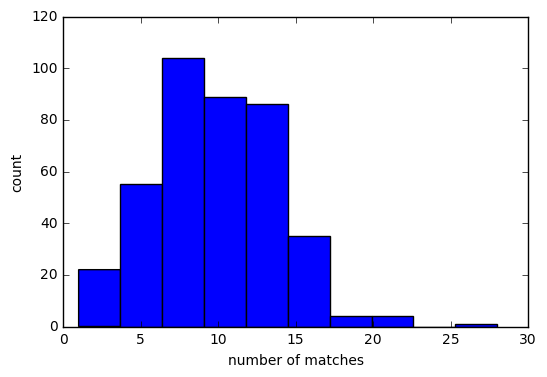

In [19]:
plt.hist(num_options)
plt.xlabel("number of matches")
plt.ylabel("count")

In [20]:
def sample_num_options(n):
    num_options = np.random.normal(loc=10, scale=4, size=(n))
    num_options = np.maximum(num_options, 1)
    return np.int32(num_options)

In [21]:
def sample_suggestions_normal(n):
    num_options = sample_num_options(n)
    data = map(sample, num_options)
    X, y = zip(*data)
    return X, y

In [22]:
def sample_suggestions_spark(n):
    num_options = sample_num_options(n)    
    data = sc.parallelize(num_options).map(sample).collect()
    X, y = zip(*data)
    return X, y

In [23]:
def sample_suggestions(n):
    if n > 1000:
        return sample_suggestions_spark(n)
    else:
        return sample_suggestions_normal(n)